In [11]:
import numpy as np

In [88]:
dirName = "txt/"
k = 10
d = 5
t = 0.2
matrix_l = []
for i in range(100):
    t_f = t*i
    t_Str = "{0:0.1f}".format(t_f)
    filename = dirName + "mesh_20_10_" + t_Str + ".txt"
    if i%5==0:
        filename = dirName + "mesh_20_10_" + str(int(t_f)) + ".txt"
    f = open ( filename , 'r')
    row_data = []
    row_data = [ line.split() for line in f]

    matix_ind = np.array([])
    matix_ind.resize((21,11))
    for i in range(len(row_data)):
        col = int(row_data[i][0])
        row = int(row_data[i][1])
        val = float(row_data[i][2])
        matix_ind[col][row] = val
    t_array = np.full((21, 11), t_f)
    matrix = np.stack((matix_ind, t_array), axis=0)
    matrix_l.append(matrix)
matrix_arr = np.array(matrix_l)

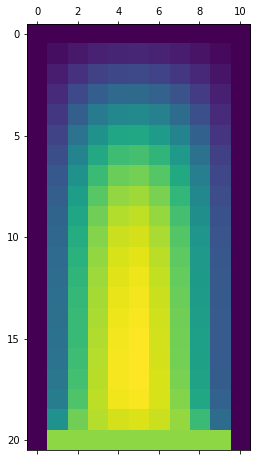

In [90]:
## %matplotlib inline 
from matplotlib import pyplot as plt
plt.matshow(matrix_arr[99,0,:,:])

plt.show()

In [95]:
tensor = tf.convert_to_tensor(matrix_arr)
tensor

<tf.Tensor 'Const_1:0' shape=(100, 2, 21, 11) dtype=float64>

In [92]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from tensorflow.examples.tutorials.mnist import input_data

sess = tf.InteractiveSession()

mb_size = 128
Z_dim = 100

mnist = input_data.read_data_sets('../../MNIST_data', one_hot=True)


/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../../MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../../MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting ../../MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting ../../MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as offi